In [1]:
from __future__ import print_function, division
import os
import torch
from skimage import io, transform, color
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
import time
import copy
import torch.nn as nn
from logger import Logger

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

# Data Set and Data Loaders

In [2]:
class ATRDataset(Dataset):
    """ATR dataset."""

    def __init__(self, images_dir, labels_dir, transform=None):
        """
        Args:
            images_dir (string): Directory with all the images.
            labels_dir (string): Directory with all the corresponding Labels.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.file_names = os.listdir(images_dir)
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_dir,
                                self.file_names[idx])
        image = io.imread(img_name)
        
        lbl_name = os.path.join(self.labels_dir,
                                self.file_names[idx].split('.')[0] + '.png')
        label = np.copy(image)
        label[:,:,0] = io.imread(lbl_name)
        label[:,:,1] = label[:,:,0]
        label[:,:,2] = label[:,:,0]
        
        glabel = np.zeros(18)
        for lbl in range(18):
            if lbl in label[:,:,0]:
                glabel[lbl] = 1
        glabel = glabel/sum(glabel)
        
        if self.transform:
            image = self.transform(image)
            label = self.transform(label)
                
        sample = {'image': image, 'label': label, 'glabel' : glabel}

        return sample

In [3]:
data_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((150,100)),
        transforms.ToTensor(),
    ])

# TODO : Add transforms.RandomHorizontalFlip(), REFER -1 to 1
# Initialize weights Using Guassian

train_dir = 'trainset/'
trainset = ATRDataset(images_dir=train_dir + 'JPEGImages/',
                                    labels_dir=train_dir+'SegmentationClassAug/',transform=data_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=12,shuffle=True, num_workers=2)

test_dir = 'testset/'
testset = ATRDataset(images_dir=test_dir + 'JPEGImages/',
                                    labels_dir=test_dir+'SegmentationClassAug/',transform=data_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=12,shuffle=False, num_workers=2)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on ",device)

Running on  cuda:0


## Visualize Sample Dataset

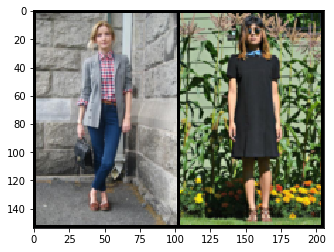

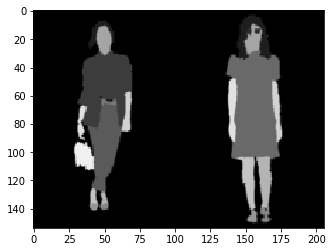

In [5]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
it = dataiter.next()
    
imshow(utils.make_grid(it['image']))
imshow(utils.make_grid(it['label']*15))

# Implement Network

In [6]:
import torch.nn as nn
import torch.nn.functional as F


class CoCNN(nn.Module):
    def __init__(self):
        super(CoCNN, self).__init__()
        ''' Local-to-Global'''
        self.conv1 = nn.Conv2d(3, 128, 5, 1, 2)
        self.conv2 = nn.Conv2d(128, 192, 5, 1, 2)
        
        self.conv3 = nn.Conv2d(192, 192, 5, 1, 2)
        self.conv4 = nn.Conv2d(192, 192, 5, 1, 2)
        
        self.conv5 = nn.Conv2d(192, 192, 5, 1, 2)
        self.conv6 = nn.Conv2d(192, 192, 5, 1, 2)

        self.conv7 = nn.Conv2d(192, 192, 5, 1, 2)
        self.conv8 = nn.Conv2d(192, 192, 5, 1, 2)

        self.pool = nn.MaxPool2d(3, 2,ceil_mode=True)
        
        ''' Image-Level label prediction'''
        self.conv9 = nn.Conv2d(192, 96, 1, 1, 0)
        self.fc1 = nn.Linear(18 * 12 * 96, 1024)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(1024, 18)
        
        ''' Global-to-Local '''
        self.upsample1 = nn.Upsample(size=(37, 25))
        self.conv10 = nn.Conv2d(192, 192, 5, 1, 2)
        
        self.conv11 = nn.Conv2d(210, 192, 5, 1, 2)
        self.upsample2 = nn.Upsample(size=(75, 50))
        self.conv12 = nn.Conv2d(192, 192, 3, 1, 1)
        
        self.conv13 = nn.Conv2d(210, 192, 5, 1, 2)
        self.upsample3 = nn.Upsample(size=(150, 100))
        self.conv14 = nn.Conv2d(192, 192, 5, 1, 2)
        
        self.conv15 = nn.Conv2d(210, 192, 5, 1, 2)
        self.conv16 = nn.Conv2d(3, 192, 3, 1, 1)
        
        self.conv17 = nn.Conv2d(192, 256, 3, 1, 1)
        self.conv18 = nn.Conv2d(256, 18, 1, 1, 0)
        self.conv19 = nn.Conv2d(18, 18, 1, 1, 0)
        
        
        
    def forward(self, x):
        
        '''Local-to-Global'''
        x1 = F.relu(self.conv1(x))
        x1 = F.relu(self.conv2(x1))
        
        x2 = self.pool(x1)
        x2 = F.relu(self.conv3(x2))
        x2 = F.relu(self.conv4(x2))
        
        x3 = self.pool(x2)
        x3 = F.relu(self.conv5(x3))
        x3 = F.relu(self.conv6(x3))
        
        x4 = self.pool(x3)
        x4 = F.relu(self.conv7(x4))
        x4 = F.relu(self.conv8(x4))
        
        ''' Image-Level label prediction'''
        y = F.relu(self.conv9(x4))
        y = y.view(-1, 18 * 12 * 96)
        y = F.relu(self.fc1(y))
        y = self.dropout(y)
        y = F.relu(self.fc2(y))
        
        y0 = y.unsqueeze(2)
        y0 = y0.unsqueeze(3)
        y1 = y0.repeat(1, 1 , 37, 25)
        y2 = y0.repeat(1, 1, 75, 50)
        y3 = y0.repeat(1, 1, 150, 100)
        
        ''' Global-to-Local '''
        x5 = self.upsample1(x4)
        x5 = F.relu(self.conv10(x5))
        x5 = x5.add(x3)
        x5 = torch.cat((x5,y1),1)
        
        x6 = F.relu(self.conv11(x5))
        x6 = self.upsample2(x6)
        x6 = F.relu(self.conv12(x6))
        x6 = x6.add(x2)
        x6 = torch.cat((x6,y2),1)
        
        x7 = F.relu(self.conv13(x6))
        x7 = self.upsample3(x7)
        x7 = F.relu(self.conv14(x7))
        x7 = x7.add(x1)
        x7 = torch.cat((x7,y3),1)
        
        x8 = F.relu(self.conv15(x7))
        x9 = F.relu(self.conv16(x))
        x8 = x8.add(x9)
        x8 = F.relu(self.conv17(x8))
        
        x9 = self.conv18(x8)
        x9 = x9.add(y3)
        x9 = self.conv19(x9)
        
        return (x9, y)

net = CoCNN()
net.to(device)
print(net)

CoCNN(
  (conv1): Conv2d(3, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(128, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(192, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(192, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv5): Conv2d(192, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv6): Conv2d(192, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv7): Conv2d(192, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv8): Conv2d(192, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv9): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=20736, out_features=1024, bias=True)
  (dropout): Dropout(p=0.3)
  (fc2): Linear(in_features=1024, out_features=18, bias=True)
  (upsample1): Upsample(size=(37, 25), mode=nearest)
  (conv10

# Loss and Optimizer and Scheduler

In [7]:
import torch.optim as optim

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Train Network

In [9]:
since = time.time()
best_model_wts = copy.deepcopy(net.state_dict())
best_acc = 0.0
logger = Logger('./logs')
model = CoCNN().to(device)

# Change number of Epochs
for epoch in range(90):
    scheduler.step()
    
    ''' Train the Network '''
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):

        net.train()
        inputs, labels, glabels = data['image'].to(device), data['label'].to(device), data['glabel'].to(device)
        labels = labels[:,0,:,:]*255
        labels = labels.squeeze(1)
        labels = labels.to(dtype=torch.int64)
        
        optimizer.zero_grad()
        out, global_out = net(inputs)
        global_out = global_out.float()
        glabels = glabels.float()
        
        loss = criterion(out, labels) 
        loss += 0.3 * (global_out - glabels).pow(2).sum()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % 10 == 9:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.6f time: %d' %
                  (epoch + 1, i + 1, running_loss / 100, int(time.time()-since)))
            running_loss = 0.0
            # start Tensorboard logging
            step = i
            info = { 'loss': loss.item()}

            for tag, value in info.items():
                logger.scalar_summary(tag, value, step+1)

            # 2. Log values and gradients of the parameters (histogram summary)
            for tag, value in model.named_parameters():
                tag = tag.replace('.', '/')
                logger.histo_summary(tag, value.data.cpu().numpy(), step+1)
            '''
                logger.histo_summary(tag+'/grad', value.grad.data.cpu().numpy(), step+1)

                #3. Log training images (image summary)
                info = { 'images': inputs.view(-1, 28, 28)[:10].cpu().numpy() }

                for tag, images in info.items():
                    logger.image_summary(tag, images, step+1)
            '''
    
    ''' Evaluate the Network '''
    val_loss = 0.0
    with torch.no_grad():
        net.eval()
        for data in testloader:
            inputs, labels, glabels = data['image'].to(device), data['label'].to(device), data['glabel'].to(device)
            labels = labels[:,0,:,:]
            labels = labels.squeeze(1)
            labels = labels.to(dtype=torch.int64)
            
            out, global_out = net(inputs)
            global_out = global_out.float()
            glabels = glabels.float()
            
            loss = criterion(out, labels) + 0.3 * (global_out - glabels).pow(2).sum()
            val_loss += loss.item()
            break
        print('[%d, val] loss: %.6f time: %d' %
              (epoch + 1, val_loss/len(testloader), int(time.time()-since)))

    # Save the model with best accuarcy 
    if 1/val_loss > best_acc:
        best_acc = 1/val_loss
        best_model_wts = copy.deepcopy(net.state_dict())
        torch.save(net.state_dict(), '../models/model_simple.pb')
        
print('Finished Training')

[1, val] loss: 0.576680 time: 3
Finished Training


# Test Network

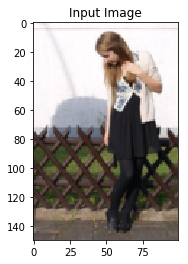

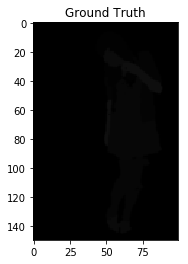

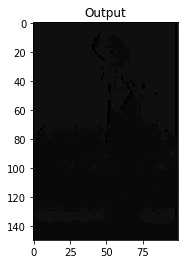

In [10]:
net.load_state_dict(torch.load('../models/model_simple.pb',map_location=device))
with torch.no_grad():
    net.eval()
    
    tmp_inp = trainset[64]
    out,g_out = net(tmp_inp['image'].unsqueeze(0).to(device))
    
    X, prediction = torch.max(out,1)
    p = prediction.cpu().numpy()
    p = p.squeeze(0)

    p_out = np.zeros((150,100,3),dtype=np.uint32)
    p_out[:,:,0] = p
    p_out[:,:,1] = p
    p_out[:,:,2] = p
    
    plt.title('Input Image')
    imshow(tmp_inp['image'])
    plt.title('Ground Truth')
    imshow(tmp_inp['label'])
    plt.imshow(p_out)
    plt.title('Output')
    plt.show()    